# Setup

In [67]:
import os
import sys
sys.path.insert(0, os.path.join(os.getcwd(), ".."))

import torch
from torch import distributions
from torch import nn
from torch.utils import data
from sklearn import datasets

import random
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

%matplotlib inline
%load_ext autoreload
%autoreload 2 # Reload all modules every time before executing the Python code typed.

import project
import project.networks.net as net
from project.models.ising   import IsingModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
random.seed(0)

# Define Ising Model

CPU times: user 372 µs, sys: 0 ns, total: 372 µs
Wall time: 378 µs


0.1875

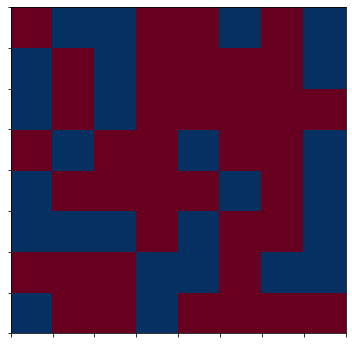

In [69]:
h = 0.0
J = 0.8
T = 1.0
N = 8

ising = IsingModel(h = h, J = J)
x0 = ising.init_coords(N)
ising.draw_config(x0)

%time ising.energy(torch.from_numpy(x0)) # energy of a given configuration 
ising.oprm(x0) # calculate average magnetization 

## Create training set
We'd like to have a $m$ x $N$ matrix containing our training data where $m$ is the number of realizations of the system and $N$ is the number of features (i.e. the flattened dimensions of the system). For example, a training set with 1000 samples of the Ising Model for $N=8$ would be of size (1000, 64). For a given row, each of these 64 columns will contain a "coordinate" of the system, taking on a value of 1 or -1. 

In [70]:
num_samples = 1000 # Use 1000 at run-time as done in Noe et al. for the biwell potential 
flattened_size = N**2

training_set = np.zeros((num_samples,flattened_size), dtype=np.float32)
for i in range(num_samples):
    training_set[i,:] = ising.init_coords(N).flatten() # generate random configuration 
training_set = torch.from_numpy(training_set) # convert to PyTorch tensor 

As an aside, note that although we flatten our configurations for training, the flattening procedure can easily be reversed via the `rehsape()` function: 

In [71]:
np.array(x0)

array([[-1,  1,  1, -1,  1,  1,  1,  1],
       [ 1,  1,  1, -1, -1,  1, -1, -1],
       [-1, -1, -1,  1, -1,  1,  1, -1],
       [-1,  1,  1,  1,  1, -1,  1, -1],
       [ 1, -1,  1,  1, -1,  1,  1, -1],
       [-1,  1, -1,  1,  1,  1,  1,  1],
       [-1,  1, -1,  1,  1,  1,  1, -1],
       [ 1, -1, -1,  1,  1, -1,  1, -1]])

In [72]:
np.array(x0).flatten().reshape((N,N))

array([[-1,  1,  1, -1,  1,  1,  1,  1],
       [ 1,  1,  1, -1, -1,  1, -1, -1],
       [-1, -1, -1,  1, -1,  1,  1, -1],
       [-1,  1,  1,  1,  1, -1,  1, -1],
       [ 1, -1,  1,  1, -1,  1,  1, -1],
       [-1,  1, -1,  1,  1,  1,  1,  1],
       [-1,  1, -1,  1,  1,  1,  1, -1],
       [ 1, -1, -1,  1,  1, -1,  1, -1]])

## Histogram energies of training set

Previously I was calculating energy as: 

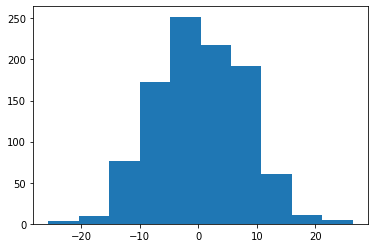

In [73]:
plt.hist(ising.energy_vec(training_set))
plt.show()

Which is clearly different from: 

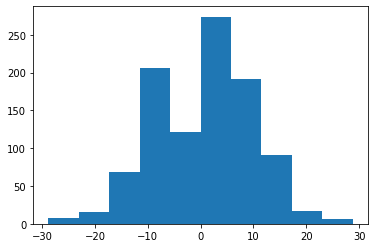

In [74]:
energies = []
for i in range(training_set.shape[0]):
    energies.append(ising.energy(training_set[i,:].reshape((N,N))))
plt.hist(energies)
plt.show()

Histogram Boltzmann weights:

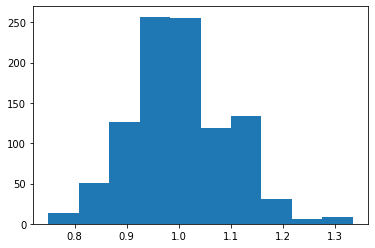

In [75]:
# KH I added a temperature so the weights could be visualized
weights = np.exp(-np.array(energies)/100)
plt.hist(weights)
plt.show()

# Boltzmann generator
## Define network architecture 
In the following we use 3 hidden layers for the translation and scaling networks and a total of four stacked RealNVP blocks (as defined by `masks`). 

In [76]:
n_hidden = 256 # number of hidden layers
nets = lambda: nn.Sequential(nn.Linear(N**2, n_hidden), nn.Tanh(), nn.Linear(n_hidden, n_hidden), nn.Tanh(), nn.Linear(n_hidden, N**2), nn.Tanh()) # net s
nett = lambda: nn.Sequential(nn.Linear(N**2, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, N**2)) # net t

first_mask = np.array(np.concatenate((np.ones(round(N**2/2)), np.zeros(round(N**2/2)))))
masks_np = np.stack(
                    ( first_mask, np.flip(first_mask, axis=0),
                      first_mask, np.flip(first_mask, axis=0),
                      first_mask, np.flip(first_mask, axis=0),
                      first_mask, np.flip(first_mask, axis=0) )
                   ) 
masks = torch.from_numpy(masks_np.astype(np.float32))

prior = distributions.MultivariateNormal(torch.zeros(N**2), torch.eye(N**2))      # so we have a total of 3 neural blocks (see fig. 1 of boltzmann generators paper)
network = net.RealNVP(nets, nett, masks, prior, ising, x0.shape)

# network.system.energy(network.g(training_set)) # energy functions need to be rewritten with PyTorch tensors in mind

Note that $\log R_{xz} = - \log R_{zx}$, as demonstrated below: 

In [77]:
z, log_Rxz = network.f(training_set[0:1,:])
x, log_Rzx = network.g(z)
print(log_Rzx)
print(log_Rxz)

tensor([0.2011], grad_fn=<AddBackward0>)
tensor([-0.2011], grad_fn=<SubBackward0>)


Energies can be calculated via the `calculate_energy()` method of the network. 

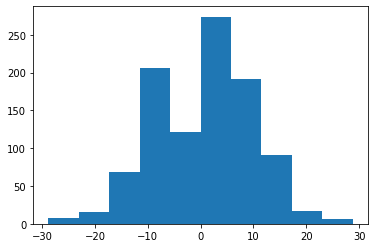

In [78]:
plt.hist(network.calculate_energy(training_set))
plt.show()

We can calculate the average energy as: 

In [79]:
network.expected_value(network.calculate_energy(training_set))

tensor(0.2720)

## Train model 
Before training let us define the optimization parameters we will consider.  Let "1" in the following denote the first set of iterations (where only the ML loss is used) while "2" refers to the second second of iterations (where both the ML and KL loss is utilized):

In [80]:
iter1 = 100
iter2 = 100

batch_size1 = num_samples 
batch_size2 = num_samples

lr1 = 1e-4 # require small loss for monotonic decrease of loss on standard gradient descent 
lr2 = 1e-4

### Train by example first
Minimizing $J_{ML}$.

In [81]:
optimizer = torch.optim.Adam([p for p in network.parameters() if p.requires_grad==True], lr=lr1)
trainloader = data.DataLoader(dataset=training_set, batch_size=batch_size1)

losses = []
avg_energy = []
t = 0 
for epoch in range(iter1):
    for batch in trainloader:  

        loss = network.loss_ml(batch)
        losses.append(loss.item()) # save values for plotting later 
        
        avg_energy.append(network.expected_value(network.energies))

        optimizer.zero_grad() # we need to set the gradients to zero before starting to do 
                              # backpropragation because PyTorch accumulates the gradients on 
                              # subsequent backward passes.
        loss.backward(retain_graph=True)
        optimizer.step()
        
        t = t + 1 # iteration count

        if t % 100 == 0:
            print('iter %s:' % t, 'loss = %.3f' % loss)

iter 100: loss = 27.608


### Training by energy
We will now train with the KL loss to teach the network to focus on low energy states. First, let's create out training set for training by energy. 

In [102]:
z, x = network.sample(num_samples)
print(z)

[[ 1.4644078  -0.232027   -0.40494615 ...  0.67715794  1.4308492
  -0.9600274 ]
 [-1.0031375  -1.2214214   1.5341016  ...  0.29757753 -0.61697173
  -1.2087357 ]
 [-0.82838714  0.955208    0.02016834 ... -1.8131317   0.28662738
  -0.73043203]
 ...
 [-0.25411347 -0.6809858  -0.20834851 ...  2.195165   -0.29229578
  -0.2358155 ]
 [ 0.14633924  0.01806322  0.8253808  ... -0.11305102 -0.505746
  -1.7103528 ]
 [ 0.3907868  -1.2597488   0.00481492 ...  2.3136134  -0.98173976
  -1.3040583 ]]


During training we will need to map latent space variables to -1 or 1 to align with the definition of the Ising model. We can achieve this as so: 

In [100]:
x_sign = np.sign(torch.from_numpy(x)) # map all values to between -1 and 1 
print(x_sign)

tensor([[ 1.,  1.,  1.,  ..., -1.,  1.,  1.],
        [ 1.,  1., -1.,  ..., -1., -1., -1.],
        [ 1., -1.,  1.,  ...,  1., -1.,  1.],
        ...,
        [-1.,  1.,  1.,  ...,  1.,  1., -1.],
        [ 1., -1.,  1.,  ..., -1.,  1.,  1.],
        [ 1., -1.,  1.,  ...,  1.,  1.,  1.]])


In [82]:
optimizer = torch.optim.Adam([p for p in network.parameters() if p.requires_grad==True], lr=lr2) 
training_set_2 = z.astype('float32')
trainloader_2 = data.DataLoader(dataset=training_set_2, batch_size=batch_size2)

while t < iter1 + iter2:
    for batch_z in trainloader_2:  
        # KL loss function
        loss = network.loss_kl(batch_z)
        losses.append(loss.item()) # save values for plotting later 
    
        # Training on KL loss
        optimizer.zero_grad() # Set grads to zero, else PyTorch will accumulate gradients on each backprop
        loss.backward(retain_graph=True)
        optimizer.step()
        
        t = t + 1 # iteration count
        if t % 25 == 0:
            print('iter %s:' % t, 'loss = %.3f' % loss)

# Visualize loss
fig = go.Figure() # plotly reference: https://plot.ly/python/line-charts/
fig.add_trace(go.Scatter(x=np.arange(len(losses)), y=losses,
                    mode='lines',
                    name='lines'))

fig.update_layout(yaxis_title='Loss', xaxis_title='Iteration #')

NameError: name 'model' is not defined

## Visualize results
### View loss as a function of iteration steps
Training should proceed until the loss approximately levels out. 

In [ ]:
fig = go.Figure() # plotly reference: https://plot.ly/python/line-charts/
fig.add_trace(go.Scatter(x=np.arange(len(losses)), y=losses,
                    mode='lines',
                    name='lines'))
# Edit the layout
fig.update_layout(yaxis_title='Loss',
                   xaxis_title='Iteration #')

### View average energy as a function of iteration steps
We should see the average energy decrease once we perform adaptive sampling during training by energy. 

In [ ]:
fig = go.Figure() # plotly reference: https://plot.ly/python/line-charts/
fig.add_trace(go.Scatter(x=np.arange(len(losses)), y=avg_energy,
                    mode='lines',
                    name='lines'))
# Edit the layout
fig.update_layout(yaxis_title='Avg. Energy',
                   xaxis_title='Iteration #')

### Procedure for adaptive sampling
The training schedule according to the the main text of Noe et al. is as follows: 
- Begin with a buffer of 10,000 real space configurations 
- Train by example, minimizing $J_{ML}$, using a batch size of 128 for 20 iterations (JB: so not even one full epoch?)
- Switch to batch size of 1000 and for each batch (iteration) we now perform a Metropolis Monte Carlo step in latent space for each sample in the given batch. 